<a href="https://colab.research.google.com/github/Priyaljain20/Mitosis-Count/blob/main/cyclegan_mitosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Dropout, concatenate, InputLayer, MaxPooling2D, UpSampling2D,BatchNormalization,Add,Activation
from tensorflow.keras.models import Model
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

#Dataset prepration#

In [ ]:
import tensorflow_datasets as tfds
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteH97M6S/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteH97M6S/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteH97M6S/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteH97M6S/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH_x = 256
IMG_HEIGHT_X = 256
IMG_WIDTH_y = 256
IMG_HEIGHT_y = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_x(image, label):
  #image = random_jitter(image)

  image = tf.image.resize(image, [128, 128],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = normalize(image)
  return image

def preprocess_image_y(image, label):
  
  image = tf.image.resize(image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = normalize(image)
  return image


In [ ]:

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_horses = train_horses.map(
    preprocess_image_x, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_y, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_x, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_y, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [ ]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

Text(0.5, 1.0, 'Horse with random jitter')

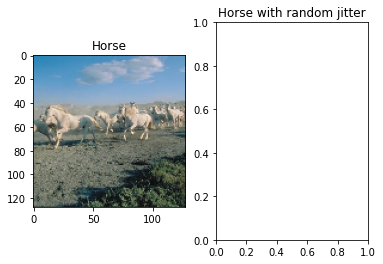

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
#plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

Text(0.5, 1.0, 'Zebra with random jitter')

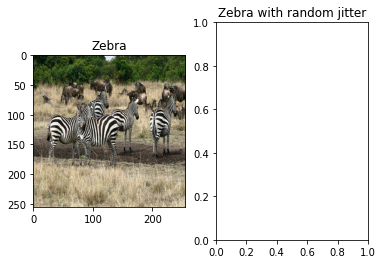

In [ ]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
#plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

#Model building#

In [ ]:
def identity_block(X,activation,padding,kernel_size,filters):
    X_skip=X
    X=Conv2D(filters,kernel_size,activation=activation,padding=padding,kernel_initializer='he_uniform')(X)
    X=BatchNormalization()(X)
    X=Conv2D(filters,kernel_size,activation=activation,padding=padding,kernel_initializer='he_uniform')(X)
    X=BatchNormalization()(X)
    X_skip=Conv2D(filters,1,activation=activation,padding=padding,kernel_initializer='he_uniform')(X_skip)
    X= Add()([X,X_skip])
    X=Activation(activation)(X)
    return X

In [ ]:
#building res2unet model 

def build_generator_kmit_to_icpr14():
    
    input_size=(128,128,3)
    inputs=tf.keras.Input(shape=input_size)
    
    conv1=identity_block(inputs,'relu','same',3,32)
    pool1=MaxPool2D(pool_size=(2,2))(conv1)
    
    conv2=identity_block(pool1,'relu','same',3,64)
    pool2=MaxPool2D(pool_size=(2,2))(conv2)
    
    conv3=identity_block(pool2,'relu','same',3,128)
    pool3=MaxPool2D(pool_size=(2,2))(conv3)
    
    conv4=identity_block(pool3,'relu','same',3,256)
    pool4=MaxPool2D(pool_size=(2,2))(conv4)
    
    conv5=identity_block(pool4,'relu','same',3,512)
    
    convtranspose4=Conv2DTranspose(512,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(conv5)
    concatenate4=concatenate([convtranspose4,conv4],axis=3)
    convrev4= identity_block(concatenate4,'relu','same',3,256)
    
    convtranspose3=Conv2DTranspose(256,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(convrev4)
    concatenate3=concatenate([convtranspose3,conv3],axis=3)
    convrev3= identity_block(concatenate3,'relu','same',3,128)
    
    convtranspose2=Conv2DTranspose(128,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(convrev3)
    concatenate2=concatenate([convtranspose2,conv2],axis=3)
    convrev2= identity_block(concatenate2,'relu','same',3,64)
    
    convtranspose1=Conv2DTranspose(64,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(convrev2)
    concatenate1=concatenate([convtranspose1,conv1],axis=3)
    convrev1= identity_block(concatenate1,'relu','same',3,32)
    
    convtranspose0=Conv2DTranspose(64,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(convrev1)
    convrev0= identity_block(convtranspose0,'relu','same',3,16)
    
    outputs= Conv2D(3,1,activation='sigmoid')(convrev0)
    
    model=Model(inputs=inputs,outputs=outputs)
    
    print(model.summary())
    return model

In [ ]:
#building res2unet model 

def build_generator_icpr14_to_kmit():
    
    input_size=(256,256,3)
    inputs=tf.keras.Input(shape=input_size)
    
    conv0=identity_block(inputs,'relu','same',3,16)
    pool0=MaxPool2D(pool_size=(2,2))(conv0)
    
    conv1=identity_block(pool0,'relu','same',3,32)
    pool1=MaxPool2D(pool_size=(2,2))(conv1)
    
    conv2=identity_block(pool1,'relu','same',3,64)
    pool2=MaxPool2D(pool_size=(2,2))(conv2)
    
    conv3=identity_block(pool2,'relu','same',3,128)
    pool3=MaxPool2D(pool_size=(2,2))(conv3)
    
    conv4=identity_block(pool3,'relu','same',3,256)
    pool4=MaxPool2D(pool_size=(2,2))(conv4)
    
    conv5=identity_block(pool4,'relu','same',3,512)
    
    convtranspose4=Conv2DTranspose(512,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(conv5)
    concatenate4=concatenate([convtranspose4,conv4],axis=3)
    convrev4= identity_block(concatenate4,'relu','same',3,256)
    
    convtranspose3=Conv2DTranspose(256,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(convrev4)
    concatenate3=concatenate([convtranspose3,conv3],axis=3)
    convrev3= identity_block(concatenate3,'relu','same',3,128)
    
    convtranspose2=Conv2DTranspose(128,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(convrev3)
    concatenate2=concatenate([convtranspose2,conv2],axis=3)
    convrev2= identity_block(concatenate2,'relu','same',3,64)
    
    convtranspose1=Conv2DTranspose(64,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(convrev2)
    concatenate1=concatenate([convtranspose1,conv1],axis=3)
    convrev1= identity_block(concatenate1,'relu','same',3,32)
    
    
    outputs= Conv2D(3,1,activation='sigmoid')(convrev1)
    
    model=Model(inputs=inputs,outputs=outputs)
    
    print(model.summary())
    return model

In [ ]:
def discriminator_icpr14():
    
    input_size=(256,256,3)
    
    model=tf.keras.applications.VGG16(
        include_top=True, weights=None, input_tensor=None, input_shape=input_size,
        pooling=None, classes=1, classifier_activation='softmax')
    return model

In [ ]:
def discriminator_kmit():
    
    input_size=(128,128,3)
    
    model=tf.keras.applications.VGG16(
        include_top=True, weights=None, input_tensor=None, input_shape=input_size,
        pooling=None, classes=1, classifier_activation='softmax')
    return model

In [ ]:
generator_g=build_generator_kmit_to_icpr14()
generator_f=build_generator_icpr14_to_kmit()
type(generator_g)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        batch_normalization[0][0]        
_______________________________________________________________________________________

tensorflow.python.keras.engine.functional.Functional

In [ ]:
discriminator_x=discriminator_kmit()
discriminator_y=discriminator_icpr14()
type(discriminator_x.summary())
type(discriminator_y.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

NoneType

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 40

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    ##print("hi1")
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    ##print("hi2")
    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    #print("hi3")
    # same_x and same_y are used for identity loss.
    #same_x = generator_f(real_x, training=True)
    #same_y = generator_g(real_y, training=True)

    ##print("hi3")
    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    ##print("hi4")
    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    ##print(disc_real_x," ",disc_real_y)
    ##print(disc_fake_x," ",disc_fake_y)

    ##print("hi5")
    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    ##print("hi6")
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    ##print("hi7")
    ##print(gen_g_loss)
    ##print("--------",total_cycle_loss)
    #print("realy",real_y)
    #print("samey",same_y)
    #print("---------",identity_loss(real_y,same_y))
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss #+ identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss #+ identity_loss(real_x, same_x)

    ##print("hi8")
    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  ##print("hi9")
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:

for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    
    #shape
    print(image_x.shape,generator_g(image_x).shape,generator_f(generator_g(image_x)).shape)
    print(discriminator_x(image_x).shape,discriminator_y(generator_g(image_x)).shape,discriminator_x(generator_f(generator_g(image_x))).shape)
    
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))

(1, 128, 128, 3) (1, 256, 256, 3) (1, 128, 128, 3)
(1, 1) (1, 1) (1, 1)
.(1, 128, 128, 3) (1, 256, 256, 3) (1, 128, 128, 3)
(1, 1) (1, 1) (1, 1)
(1, 128, 128, 3) (1, 256, 256, 3) (1, 128, 128, 3)
(1, 1) (1, 1) (1, 1)
(1, 128, 128, 3) (1, 256, 256, 3) (1, 128, 128, 3)
(1, 1) (1, 1) (1, 1)
(1, 128, 128, 3) (1, 256, 256, 3) (1, 128, 128, 3)
(1, 1) (1, 1) (1, 1)
(1, 128, 128, 3) (1, 256, 256, 3) (1, 128, 128, 3)
(1, 1) (1, 1) (1, 1)
(1, 128, 128, 3) (1, 256, 256, 3) (1, 128, 128, 3)
(1, 1) (1, 1) (1, 1)
(1, 128, 128, 3) (1, 256, 256, 3) (1, 128, 128, 3)
(1, 1) (1, 1) (1, 1)
(1, 128, 128, 3) (1, 256, 256, 3) (1, 128, 128, 3)
(1, 1) (1, 1) (1, 1)
(1, 128, 128, 3) (1, 256, 256, 3) (1, 128, 128, 3)
(1, 1) (1, 1) (1, 1)
(1, 128, 128, 3) (1, 256, 256, 3) (1, 128, 128, 3)
(1, 1) (1, 1) (1, 1)
.(1, 128, 128, 3) (1, 256, 256, 3) (1, 128, 128, 3)
(1, 1) (1, 1) (1, 1)
(1, 128, 128, 3) (1, 256, 256, 3) (1, 128, 128, 3)
(1, 1) (1, 1) (1, 1)
(1, 128, 128, 3) (1, 256, 256, 3) (1, 128, 128, 3)
(1, 1) (1, 

KeyboardInterrupt: ignored

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

NameError: ignored